### Random forest model for zero vs. non-zero p_karst

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import xgboost

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [3]:
p_karst_with_controls = gpd.read_file('temp_p_karst_with_controls_5070.shp')
p_karst_with_controls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29068 entries, 0 to 29067
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    29068 non-null  float64 
 1   tnmid       29068 non-null  object  
 2   metasource  11319 non-null  object  
 3   sourcedata  655 non-null    object  
 4   sourceorig  675 non-null    object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    29011 non-null  object  
 7   referenceg  174 non-null    object  
 8   areaacres   29068 non-null  float64 
 9   areasqkm    29068 non-null  float64 
 10  states      29068 non-null  object  
 11  huc12       29068 non-null  object  
 12  name        29068 non-null  object  
 13  hutype      29068 non-null  object  
 14  humod       29060 non-null  object  
 15  tohuc       29068 non-null  object  
 16  noncontrib  27978 non-null  float64 
 17  noncontr_1  27898 non-null  float64 
 18  globalid    29068 non-null  object  
 

In [40]:
p_karst_with_controls.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 'dominant_r',
       'exposure_i', 'huc_carb_i', 'huc_pct_ar', 'median_slo', 'max_elev',
       'min_elev', 'f_steep', 'geometry'],
      dtype='object')

In [184]:
"""XY = p_karst_with_controls.loc[:, ['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo',  'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', ]]
"""
XY = p_karst_with_controls.loc[:, ['mean annua', 'annual pre',        
       'huc_carb_i', 'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 
        'huc_carb_i',]]

Y = XY.p_karst > 0
#X['dominant_r'] = X['dominant_r'].astype('category')
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 29066 entries, 0 to 29067
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean annua  29066 non-null  float64
 1   annual pre  29066 non-null  float64
 2   huc_carb_i  29066 non-null  float64
dtypes: float64(3)
memory usage: 908.3 KB


In [185]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
"""numerical_features = ['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo',]
""" 
numerical_features = ['mean annua', 'annual pre', 
       'huc_carb_i',]
hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('num', 'passthrough',
                                 ['mean annua', 'annual pre', 'huc_carb_i'])],
                  verbose_feature_names_out=False)

### Random forest model for zero vs. non-zero p_karst

In [186]:
from sklearn.pipeline import make_pipeline
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingClassifier(
        categorical_features="from_dtype",
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('num', 'passthrough',
                                                  ['mean annua', 'annual pre',
                                                   'huc_carb_i'])],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features='from_dtype',
                                                max_iter=50, random_state=0))])

In [187]:
"""#clf = RandomForestClassifier(max_depth=10, random_state=0)
clf = HistGradientBoostingClassifier(max_iter=100, categorical_features="from_dtype")
clf.fit(X_train, y_train) 
"""

'#clf = RandomForestClassifier(max_depth=10, random_state=0)\nclf = HistGradientBoostingClassifier(max_iter=100, categorical_features="from_dtype")\nclf.fit(X_train, y_train) \n'

In [189]:
hgbdt_model.score(X_test, y_test)

0.8490436218522086

In [156]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [79]:

mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

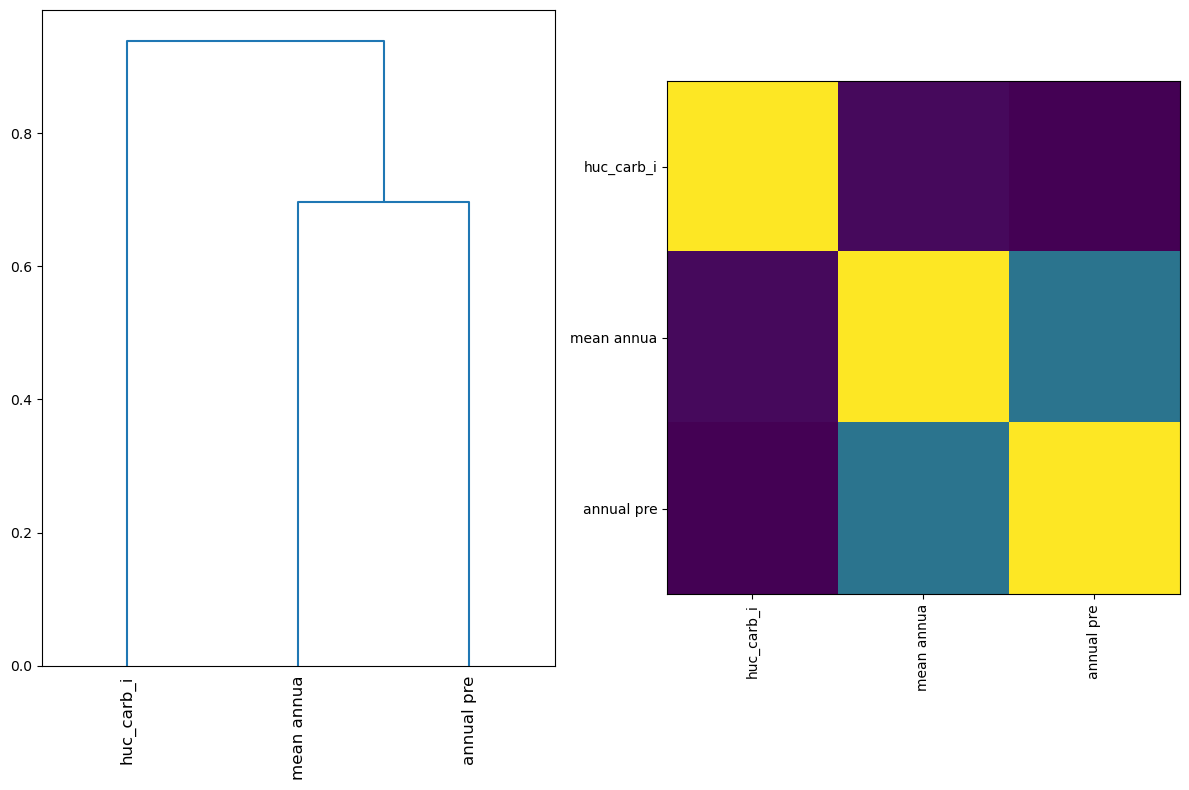

In [190]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [95]:
spearmanr(X['annual pre'], X['precipitat'])

SpearmanrResult(correlation=-0.5798947701125008, pvalue=0.0)

In [69]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.4, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

#clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel = HistGradientBoostingClassifier(max_iter=100, categorical_features="from_dtype")

clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.87


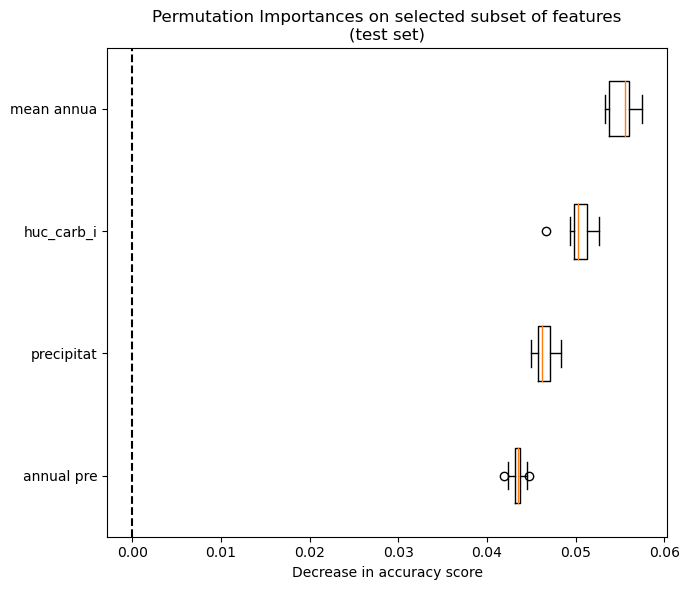

In [158]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(hgbdt_model, X_train, y_train, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

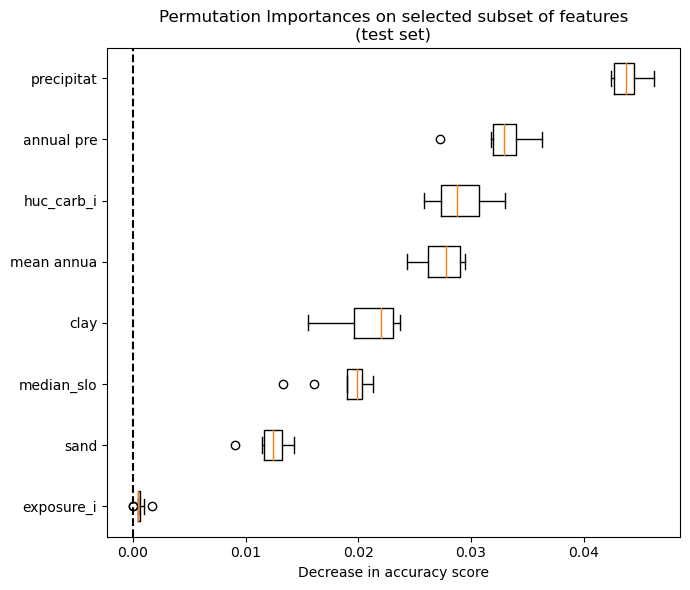

In [70]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

Computing partial dependence plots...


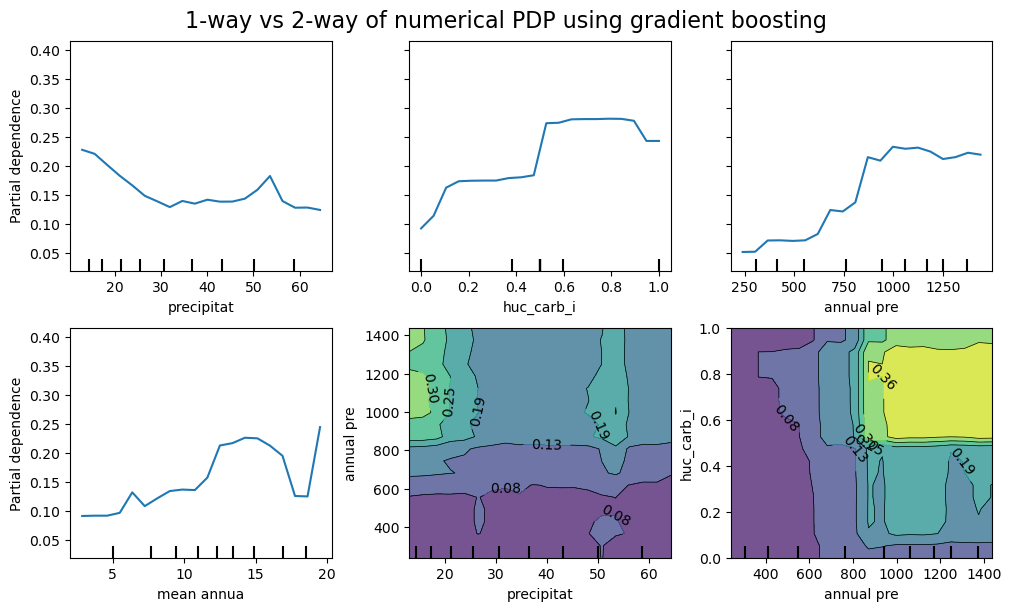

In [94]:
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    "features": ["precipitat", "huc_carb_i","annual pre", "mean annua",
                 ("precipitat", "annual pre"), ("annual pre", "huc_carb_i")],
    "kind": "average",
}
_, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

Computing partial dependence plots...


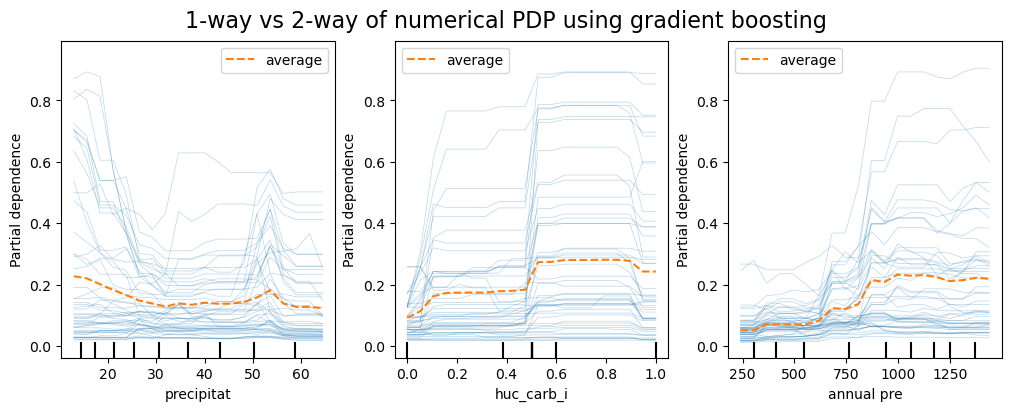

In [90]:
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    "features": ["precipitat", "huc_carb_i","annual pre", ],
    "kind": "both",
    "centered":False,
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

In [82]:
from sklearn.base import clone

interaction_cst = [[i] for i in range(X_train.shape[1])]
hgbdt_model_without_interactions = (
    clone(hgbdt_model)
    .set_params(histgradientboostingclassifier__interaction_cst=interaction_cst)
    .fit(X_train, y_train)
)
print(f"Test R2 score: {hgbdt_model_without_interactions.score(X_test, y_test):.2f}")

Test R2 score: 0.84


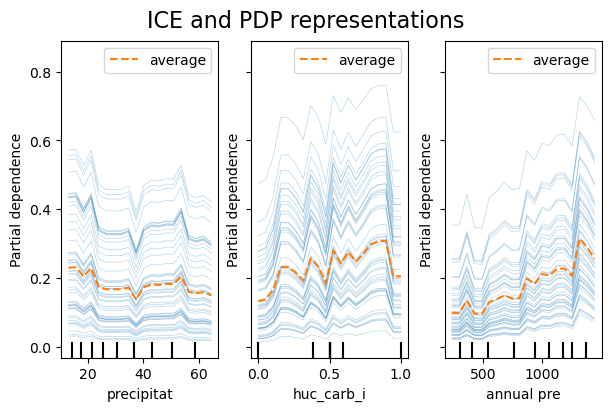

In [89]:
_, ax = plt.subplots(ncols=3, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["precipitat", "huc_carb_i", "annual pre"],
    "kind": "both",
    "centered":False,
}
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model_without_interactions,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

In [96]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [192]:
X1000 = shap.utils.sample(X_train, 500)
explainer = shap.Explainer(hgbdt_model.predict, X1000)
shap_values = explainer(X_test)

ExactExplainer explainer: 7268it [00:34, 139.93it/s]                          


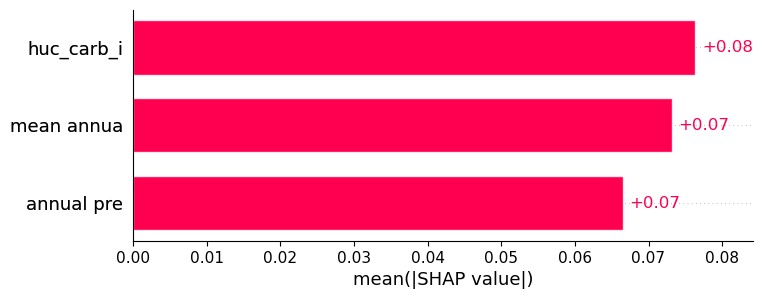

In [193]:
shap.plots.bar(shap_values)

In [115]:
shap_values.feature_names

['mean annua',
 'annual pre',
 'precipitat',
 'clay',
 'sand',
 'exposure_i',
 'huc_carb_i',
 'median_slo']

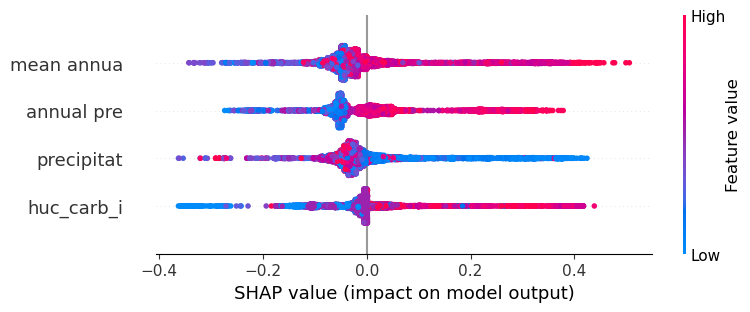

In [162]:
shap.plots.beeswarm(shap_values)

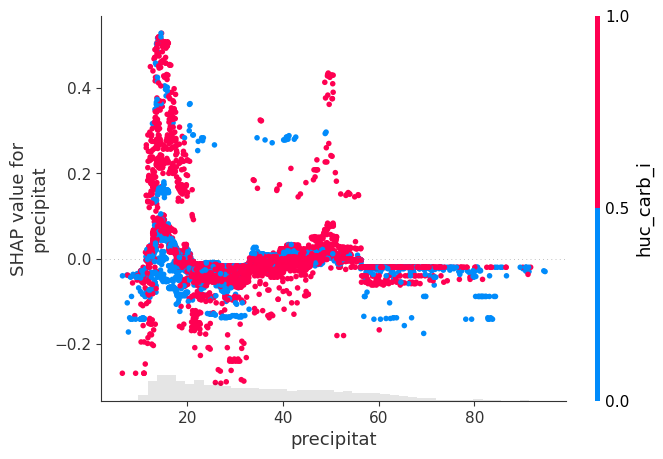

In [174]:
shap.plots.scatter(shap_values[:,"precipitat"], color=shap_values)

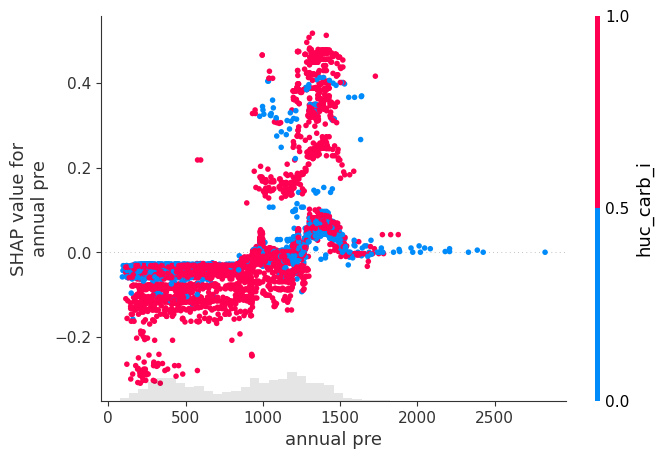

In [194]:
shap.plots.scatter(shap_values[:,"annual pre"], color=shap_values)

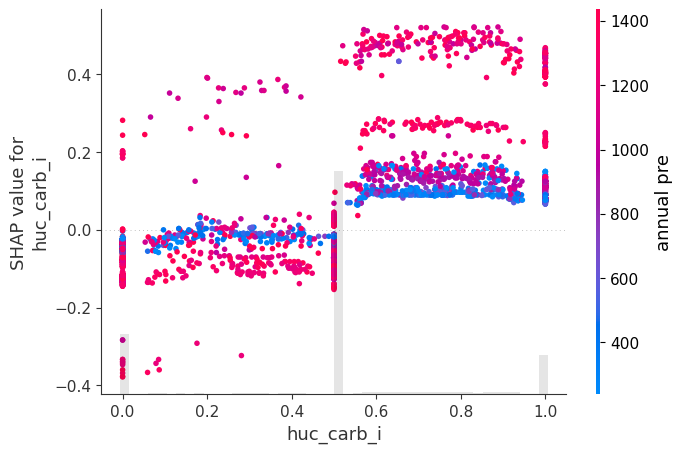

In [195]:
shap.plots.scatter(shap_values[:,"huc_carb_i"], color=shap_values)

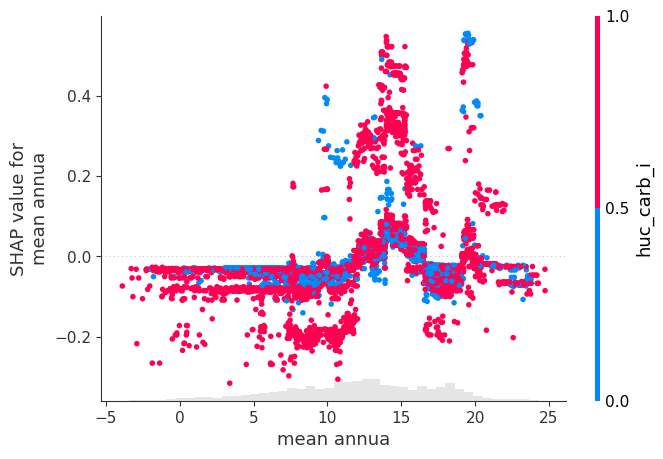

In [196]:
shap.plots.scatter(shap_values[:,"mean annua"], color=shap_values)

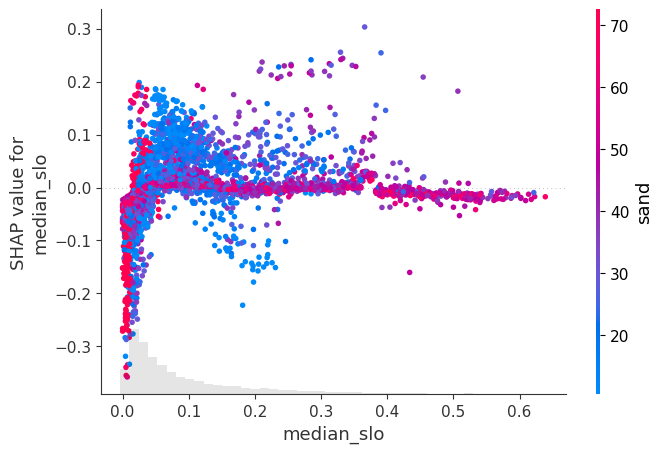

In [149]:
shap.plots.scatter(shap_values[:,"median_slo"], color=shap_values)

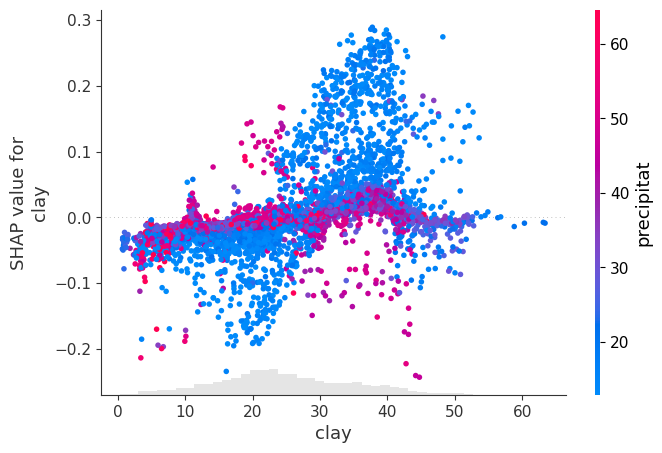

In [144]:
shap.plots.scatter(shap_values[:,"clay"], color=shap_values)

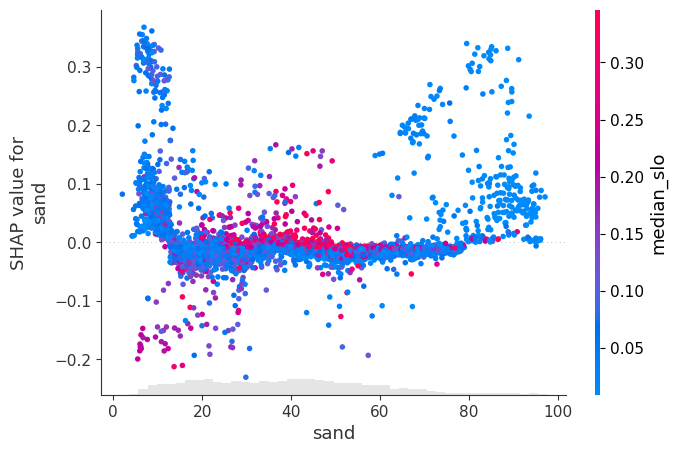

In [150]:
shap.plots.scatter(shap_values[:,"sand"], color=shap_values)

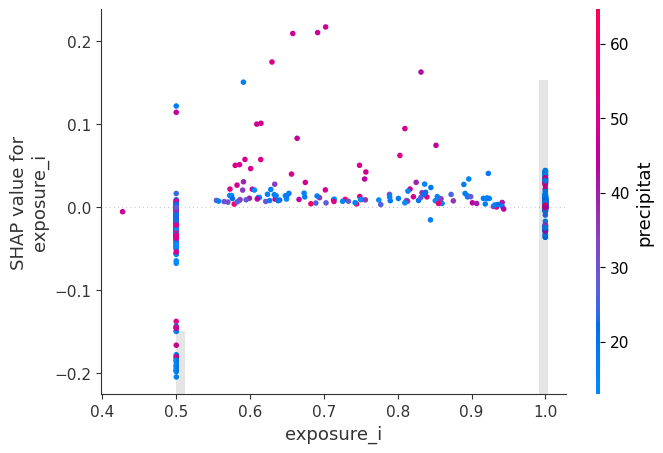

In [151]:
shap.plots.scatter(shap_values[:,"exposure_i"], color=shap_values)

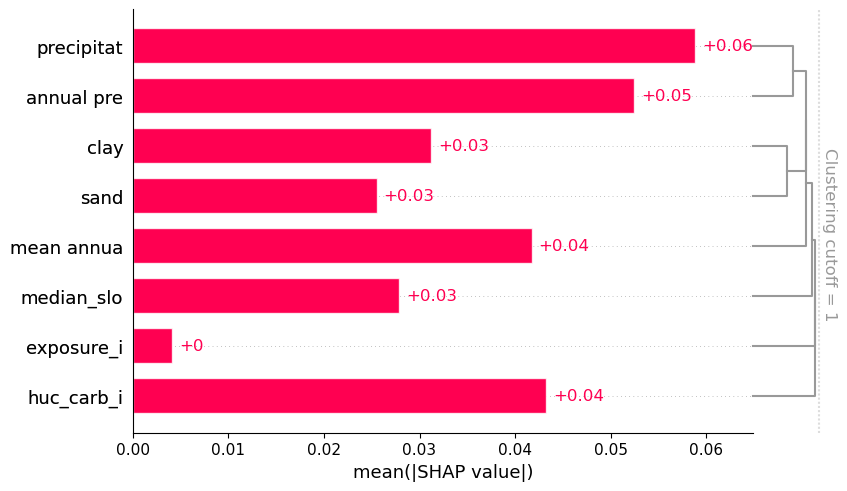

In [143]:
clustering = shap.utils.hclust(X_train_sel, y_train)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1)

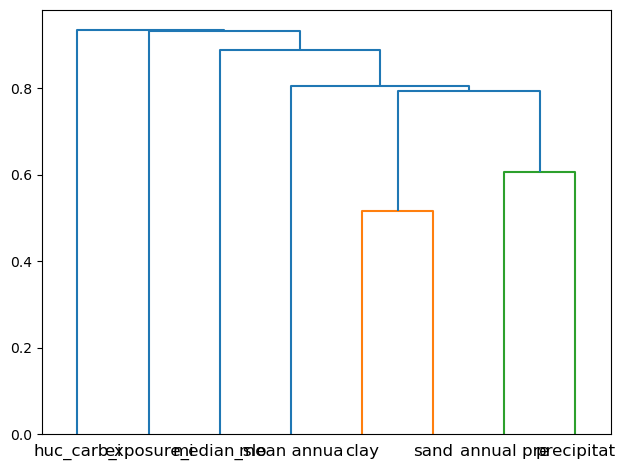

In [133]:
from scipy.cluster.hierarchy import dendrogram
dendrogram(clustering, labels=shap_values.feature_names)
plt.tight_layout()

In [135]:
shap.plots.heatmap(shap_values)

TypeError: 2nd argument metric must be a string identifier or a function.

In [138]:
clust = shap_values.hclust()

In [179]:
clf = xgboost.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train,y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-logloss:0.42456
[1]	validation_0-logloss:0.39444
[2]	validation_0-logloss:0.37729
[3]	validation_0-logloss:0.36588
[4]	validation_0-logloss:0.35819
[5]	validation_0-logloss:0.35369
[6]	validation_0-logloss:0.35031
[7]	validation_0-logloss:0.34709
[8]	validation_0-logloss:0.34384
[9]	validation_0-logloss:0.34253
[10]	validation_0-logloss:0.34124
[11]	validation_0-logloss:0.34036
[12]	validation_0-logloss:0.34031
[13]	validation_0-logloss:0.33984
[14]	validation_0-logloss:0.33783
[15]	validation_0-logloss:0.33738
[16]	validation_0-logloss:0.33665
[17]	validation_0-logloss:0.33653
[18]	validation_0-logloss:0.33570
[19]	validation_0-logloss:0.33588
[20]	validation_0-logloss:0.33482
[21]	validation_0-logloss:0.33459
[22]	validation_0-logloss:0.33478
[23]	validation_0-logloss:0.33498


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [181]:
clf.score(X_test, y_test)

0.8612907664786019

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

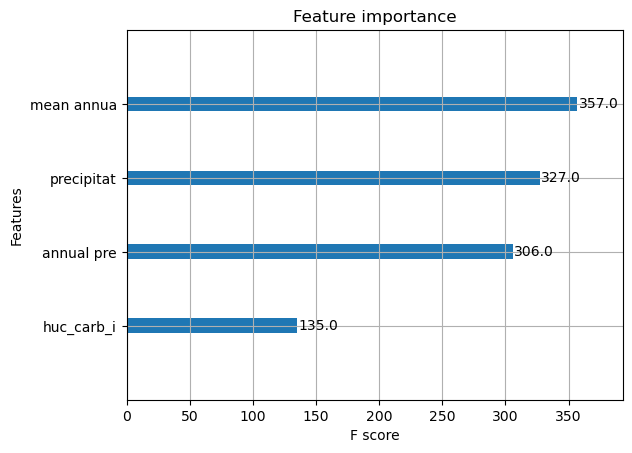

In [182]:
xgboost.plot_importance(clf)

In [5]:
p_karst_with_controls_nonzero = p_karst_with_controls[p_karst_with_controls.p_karst>0]

p_karst_with_controls_nonzero.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 'dominant_r',
       'exposure_i', 'huc_carb_i', 'huc_pct_ar', 'median_slo', 'max_elev',
       'min_elev', 'f_steep', 'geometry'],
      dtype='object')

In [31]:
XY = p_karst_with_controls_nonzero.loc[:, ['mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i',  'median_slo', 'max_elev',
         'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', 'max_elev',
         ]]

"""
XY = p_karst_with_controls_nonzero.loc[:, ['mean annua', 'annual pre', 
       'precipitat', 'exposure_i', 'huc_carb_i', 'median_slo','clay',  'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 'clay',
       'precipitat', 'exposure_i', 'huc_carb_i', 'median_slo',]]
"""

"""XY = p_karst_with_controls_nonzero.loc[:,['exposure_i', 
       'mean annua', 'annual pre',
       'precipitat',  'huc_carb_i',
        'clay', 
       'organic ma',   'sand', 'silt',
       'p_karst', 'median_slo']].copy()
X = XY.loc[:,['exposure_i', 
       'mean annua', 'annual pre',
       'precipitat', 'huc_carb_i',
        'clay', 
       'organic ma',  'sand', 'silt',
       'median_slo']]
"""

Y = np.log10(XY.p_karst)
#X['dominant_r'] = X['dominant_r'].astype('category')
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 11 to 29050
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean annua  5510 non-null   float64
 1   annual pre  5510 non-null   float64
 2   precipitat  5510 non-null   float64
 3   net primar  5510 non-null   float64
 4   cmi mean    5510 non-null   float64
 5   carbonate   5510 non-null   float64
 6   clay        5510 non-null   float64
 7   organic ma  5510 non-null   float64
 8   ph          5510 non-null   float64
 9   sand        5510 non-null   float64
 10  silt        5510 non-null   float64
 11  exposure_i  5510 non-null   float64
 12  huc_carb_i  5510 non-null   float64
 13  median_slo  5510 non-null   float64
 14  max_elev    5510 non-null   float64
dtypes: float64(15)
memory usage: 688.8 KB


In [9]:
clf = xgboost.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train,y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-rmse:0.80374
[1]	validation_0-rmse:0.77675
[2]	validation_0-rmse:0.75246
[3]	validation_0-rmse:0.74305
[4]	validation_0-rmse:0.72441
[5]	validation_0-rmse:0.71247
[6]	validation_0-rmse:0.70910
[7]	validation_0-rmse:0.70518
[8]	validation_0-rmse:0.70324
[9]	validation_0-rmse:0.70115
[10]	validation_0-rmse:0.69996
[11]	validation_0-rmse:0.69489
[12]	validation_0-rmse:0.69337
[13]	validation_0-rmse:0.69314
[14]	validation_0-rmse:0.69363


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
clf.score(X_test,y_test)

0.3416929610551338

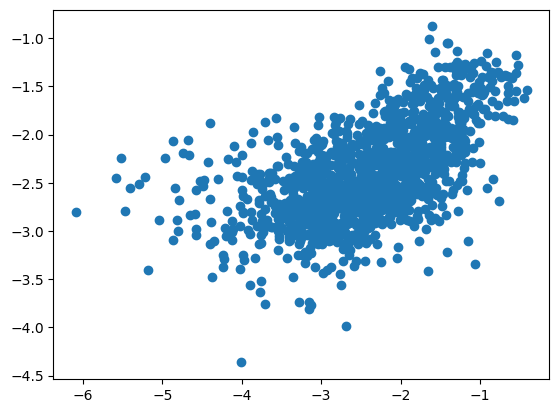

In [11]:
plt.scatter(y_test, clf.predict(X_test))

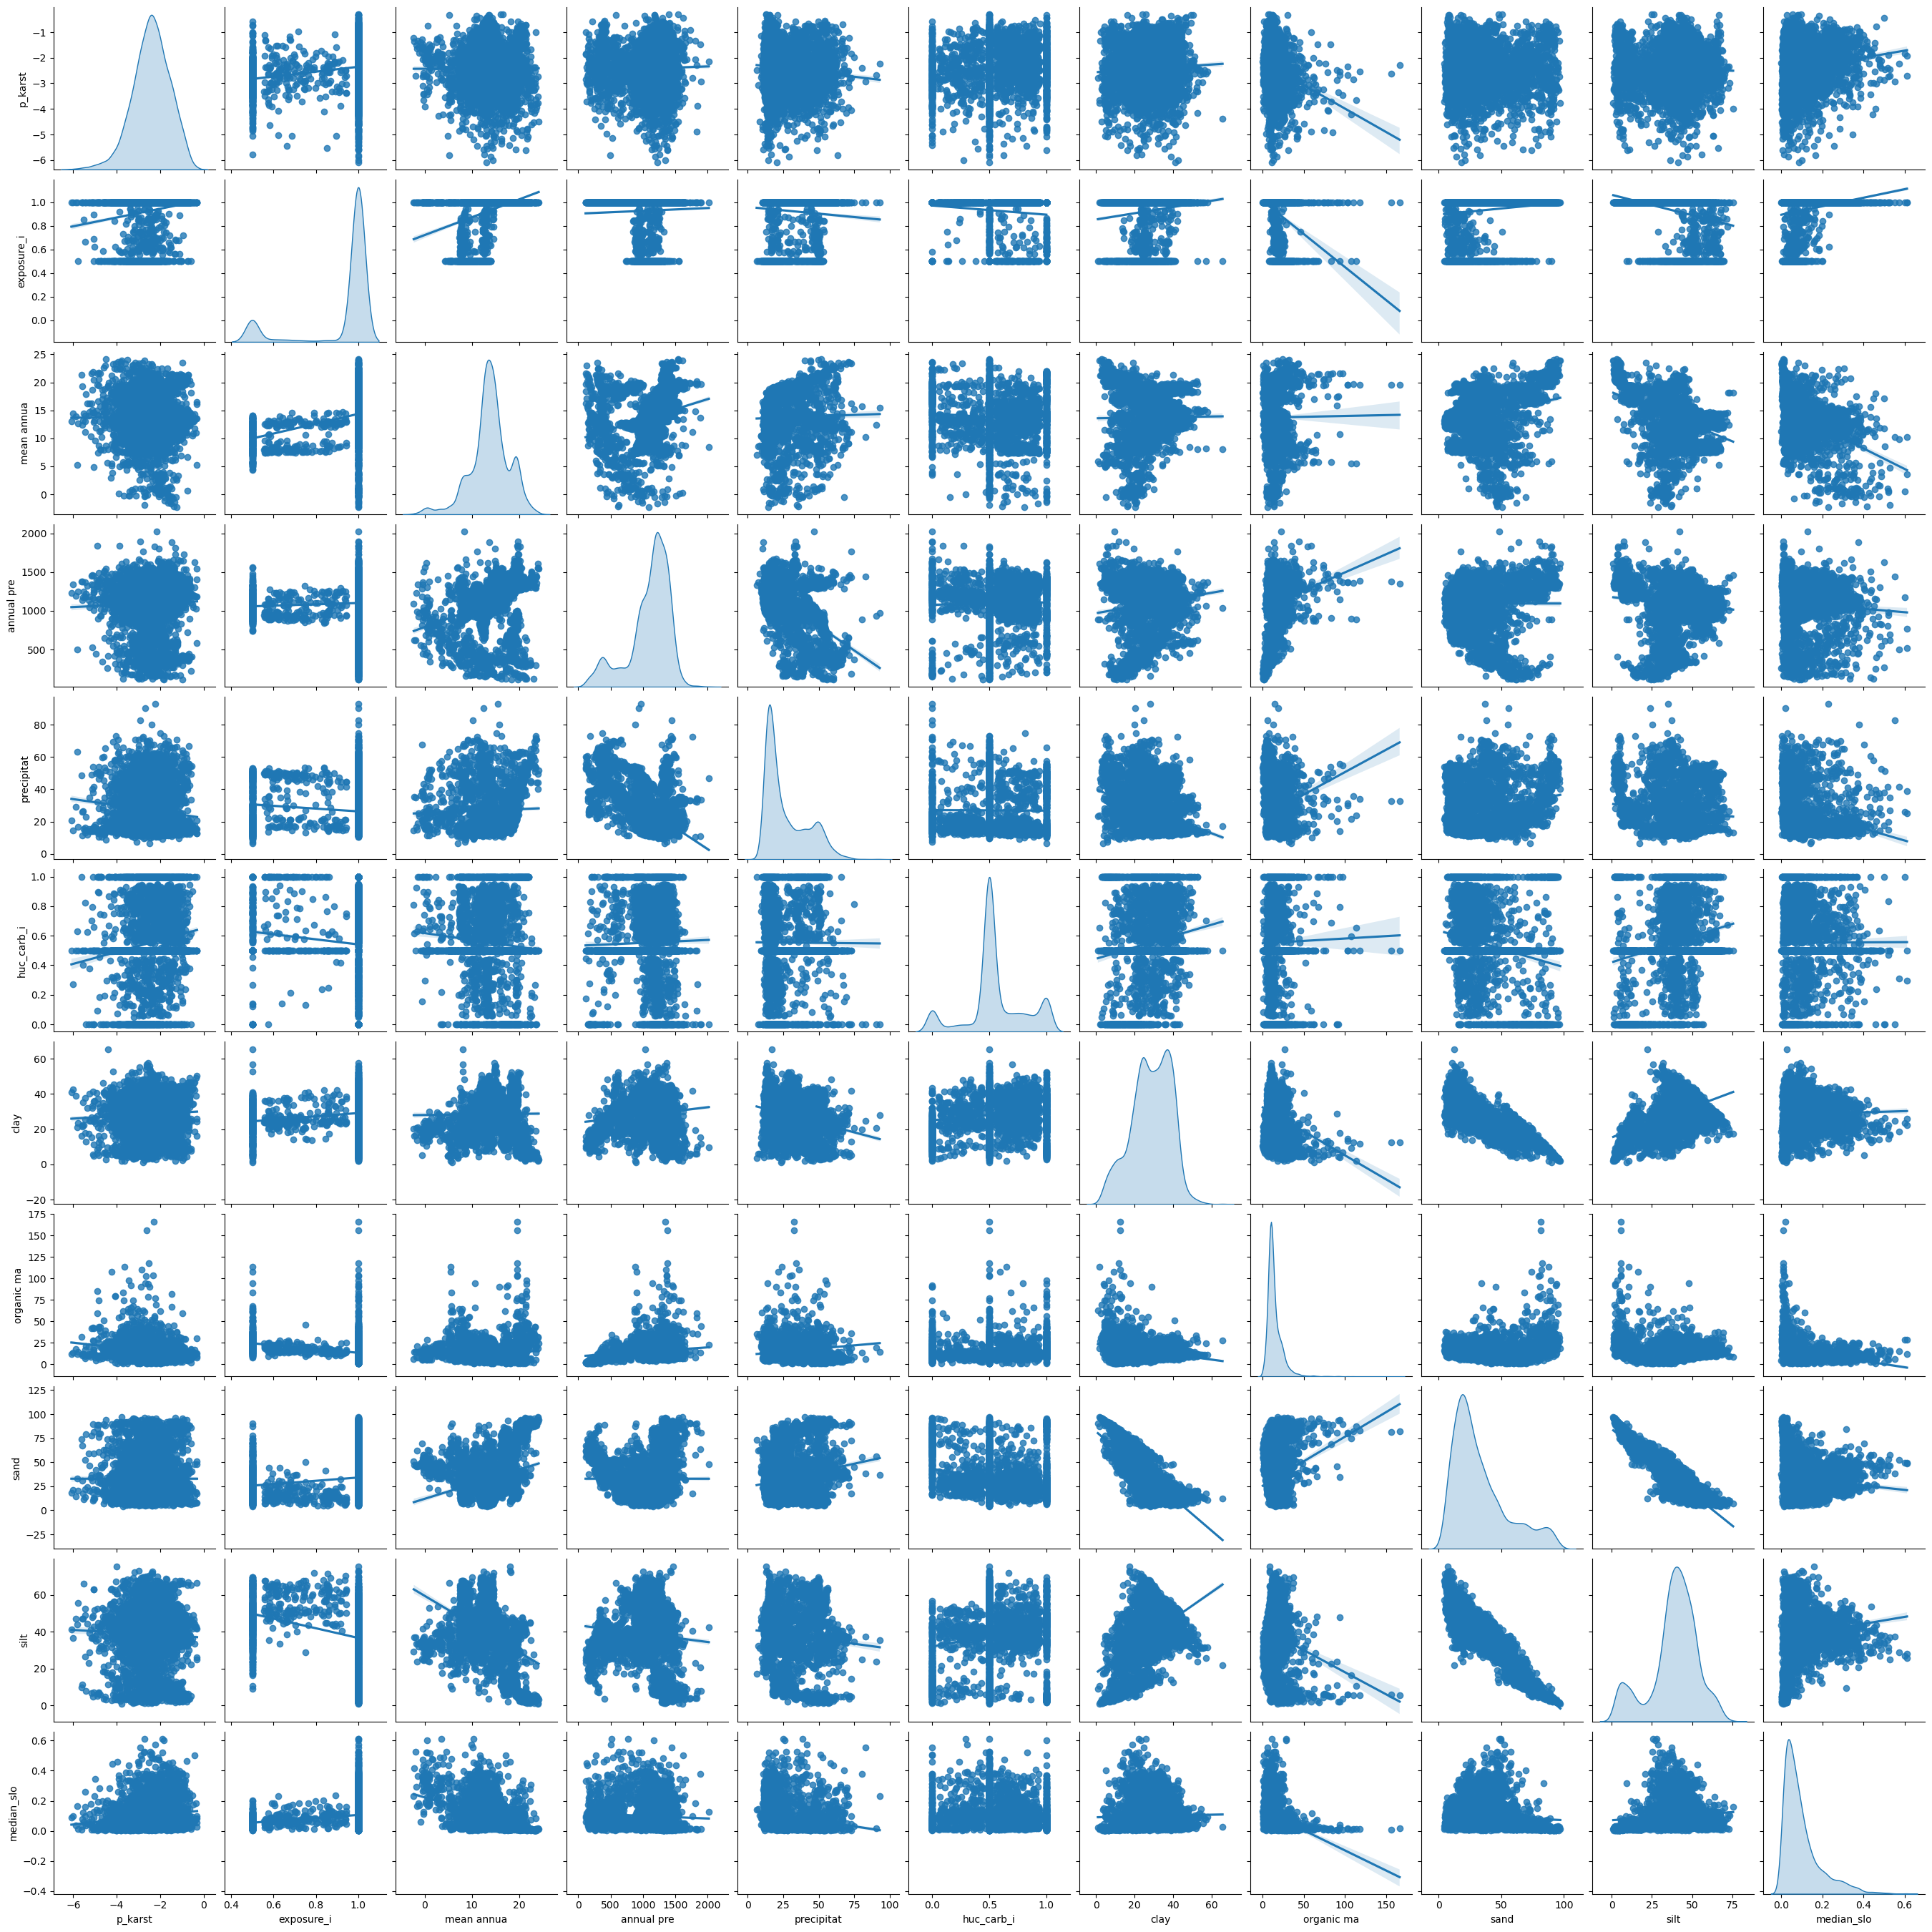

In [304]:
train_dataset = X_train.copy()
train_dataset.insert(0,"p_karst", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [13]:
import shap
X1000 = shap.utils.sample(X_train, 500)
explainer = shap.Explainer(clf.predict, X1000)
Exp = explainer(X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
PermutationExplainer explainer: 1379it [06:03,  3.71it/s]                          


In [14]:
clustering = shap.utils.hclust(X_train, y_train)

19it [00:42,  2.37s/it]                        


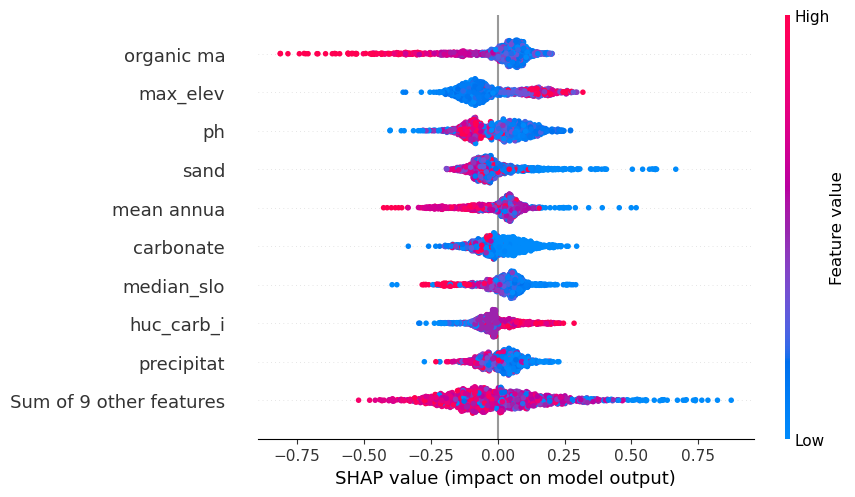

In [15]:
shap.plots.beeswarm(Exp)

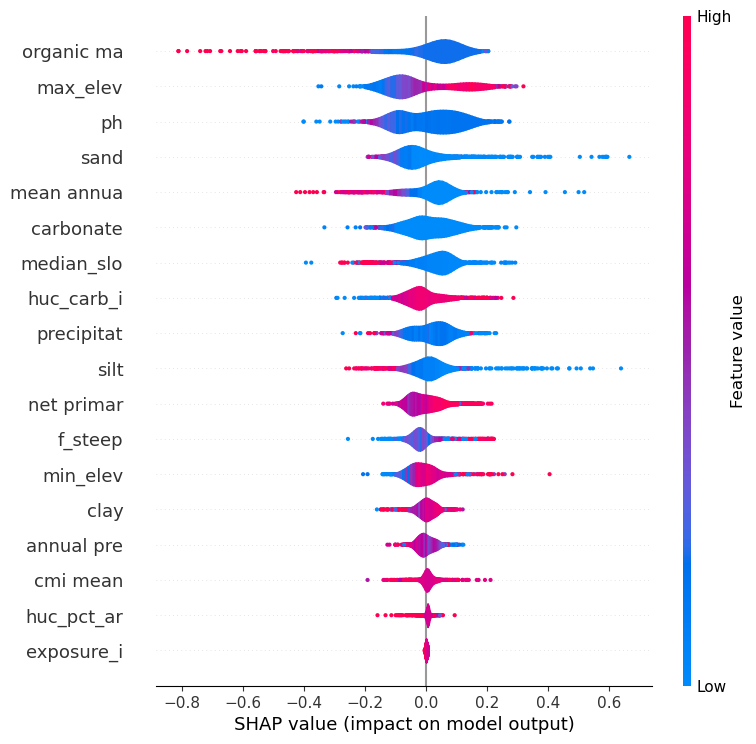

In [18]:
shap.plots.violin(Exp)

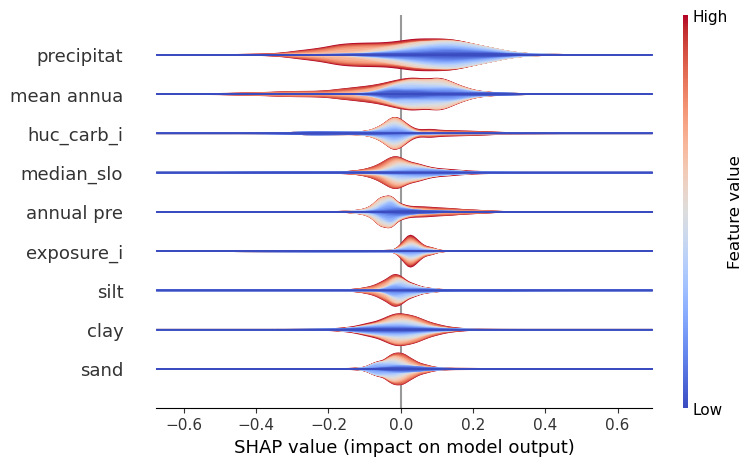

In [223]:
shap.plots.violin(Exp, plot_type='layered_violin')

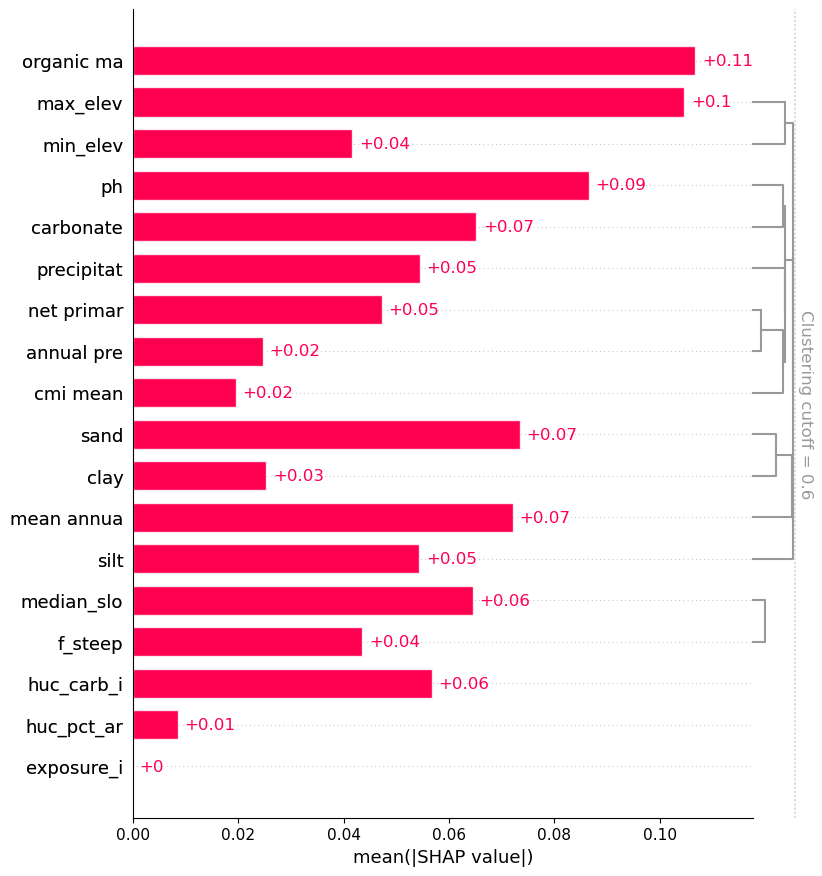

In [19]:
shap.plots.bar(Exp, max_display=18,clustering=clustering, clustering_cutoff=0.6)

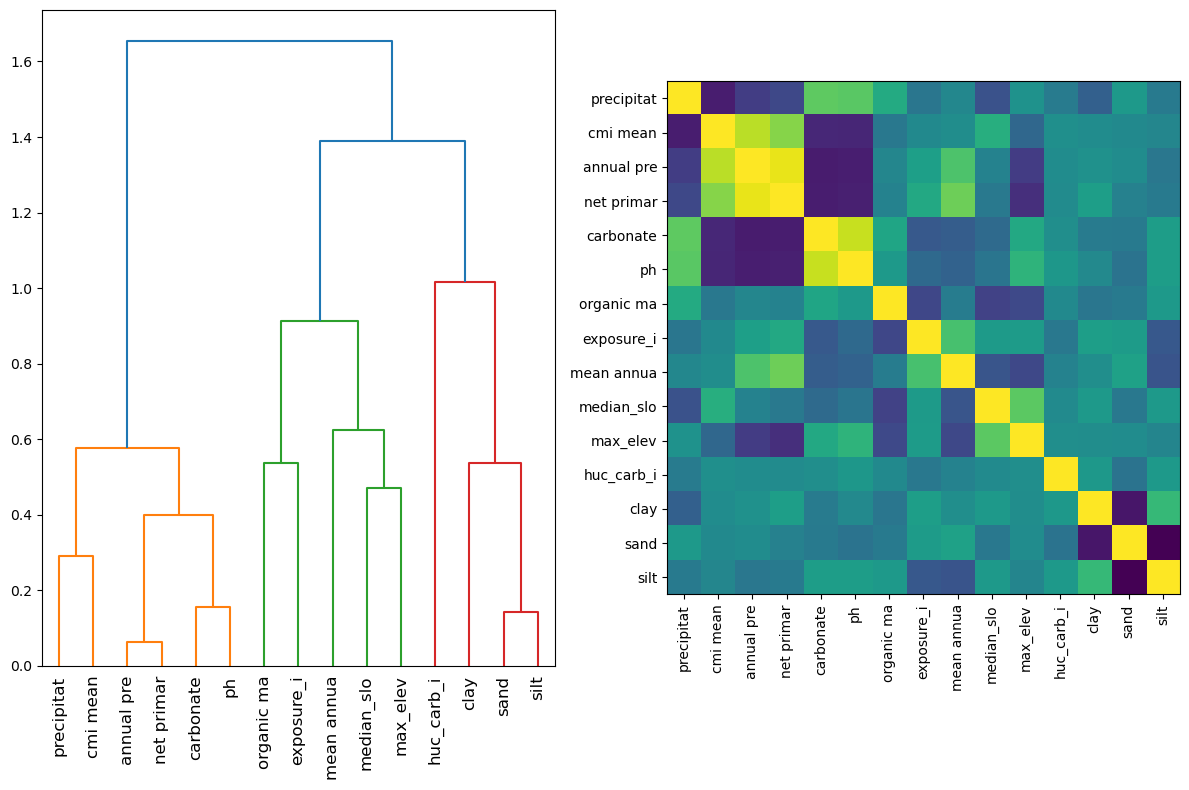

In [32]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

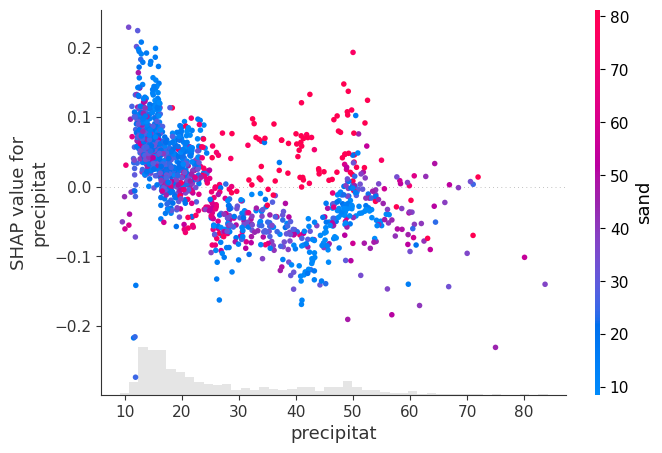

In [21]:
shap.plots.scatter(Exp[:,"precipitat"], color=Exp)

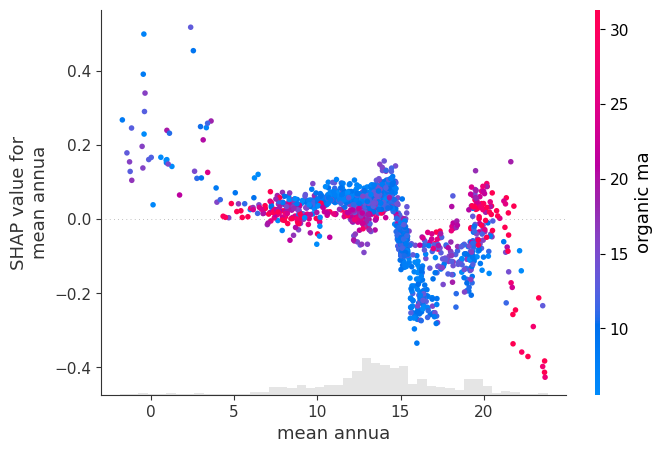

In [22]:

shap.plots.scatter(Exp[:,"mean annua"], color=Exp)


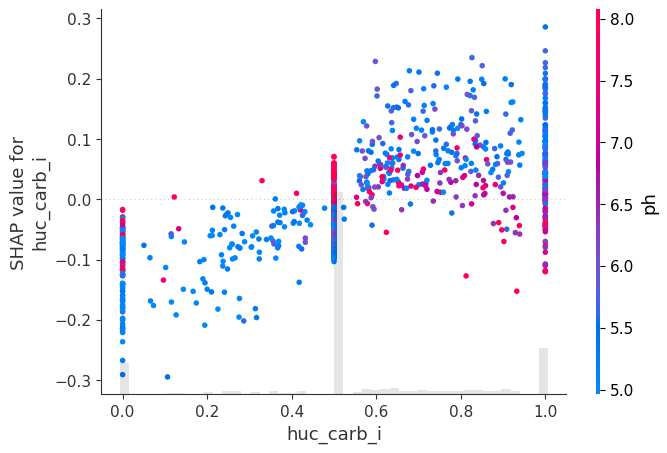

In [23]:
shap.plots.scatter(Exp[:,"huc_carb_i"], color=Exp)

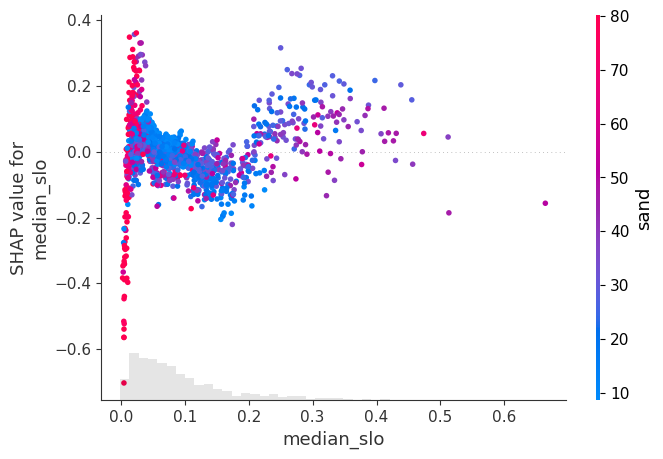

In [289]:
shap.plots.scatter(Exp[:,"median_slo"], color=Exp)

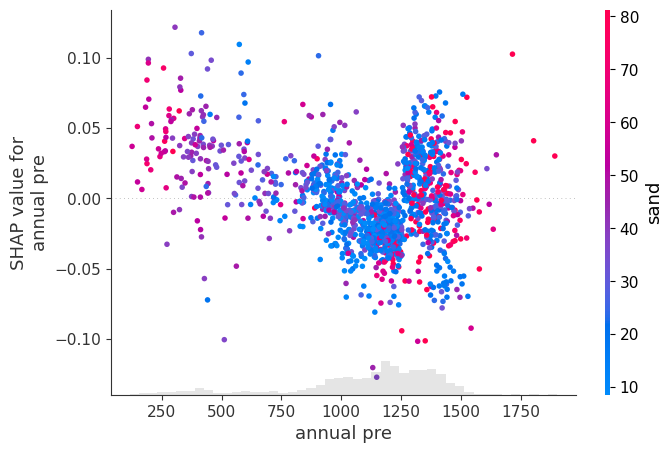

In [24]:
shap.plots.scatter(Exp[:,"annual pre"], color=Exp)

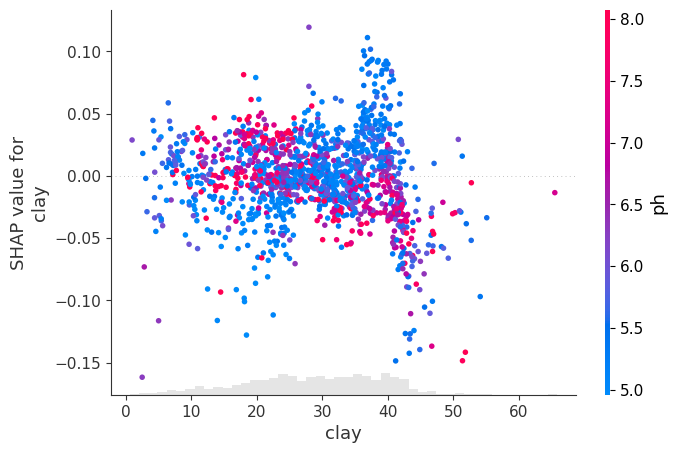

In [25]:
shap.plots.scatter(Exp[:,"clay"], color=Exp)

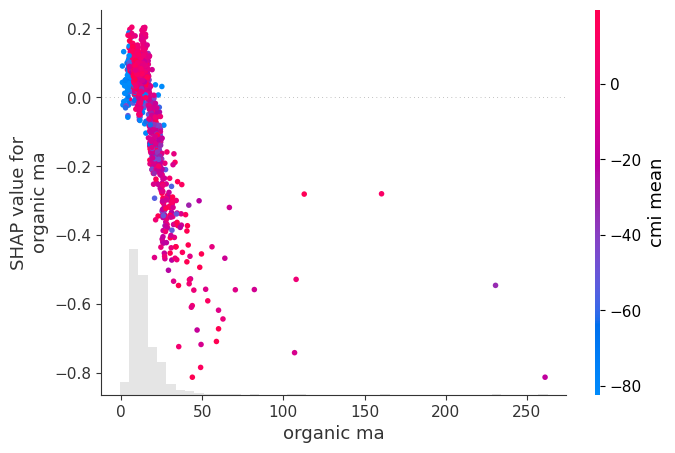

In [26]:
shap.plots.scatter(Exp[:,"organic ma"], color=Exp)

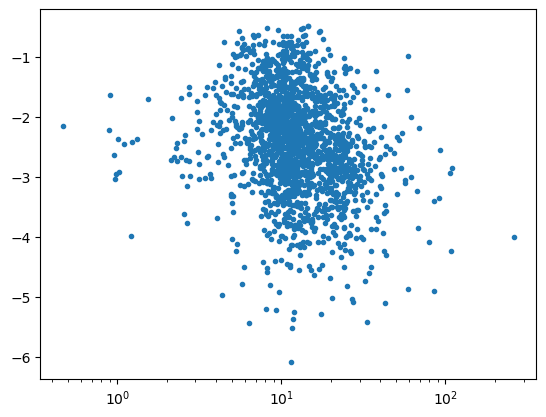

In [300]:
plt.semilogx(X['organic ma'][::3], Y[::3], '.')

In [27]:
spearmanr(X['organic ma'], Y)

SpearmanrResult(correlation=-0.2553086718224178, pvalue=1.0113752152905273e-82)

In [28]:
spearmanr(X['precipitat'], Y)

SpearmanrResult(correlation=-0.15507037184737227, pvalue=5.310956422410054e-31)

In [29]:
spearmanr(X['annual pre'], Y)

SpearmanrResult(correlation=0.09368518933421588, pvalue=3.216061729532564e-12)

In [30]:
spearmanr(X['mean annua'], Y)

SpearmanrResult(correlation=0.008058213261750094, pvalue=0.5498198327695258)

In [33]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]
selected_features_names

Index(['mean annua', 'annual pre', 'precipitat', 'clay', 'organic ma', 'sand',
       'exposure_i', 'huc_carb_i', 'median_slo'],
      dtype='object')

In [36]:
clf_sel = xgboost.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
clf_sel.fit(X_train_sel,y_train, eval_set = [(X_test_sel, y_test)])

[0]	validation_0-rmse:0.80398
[1]	validation_0-rmse:0.77483
[2]	validation_0-rmse:0.75589
[3]	validation_0-rmse:0.73927
[4]	validation_0-rmse:0.73146
[5]	validation_0-rmse:0.72404
[6]	validation_0-rmse:0.71866
[7]	validation_0-rmse:0.71511
[8]	validation_0-rmse:0.71429
[9]	validation_0-rmse:0.71121
[10]	validation_0-rmse:0.70798
[11]	validation_0-rmse:0.71082
[12]	validation_0-rmse:0.71091


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
clf_sel.score(X_test_sel, y_test)

0.3131878653155956

In [41]:

X500_sel = shap.utils.sample(X_train_sel, 500)
explainer_sel = shap.Explainer(clf_sel.predict, X500_sel)
Exp_sel = explainer_sel(X_test_sel)

ExactExplainer explainer: 1379it [00:50, 21.55it/s]                          


In [47]:
clustering = shap.utils.hclust(X_train_sel, y_train)

10it [00:13,  3.32s/it]                      


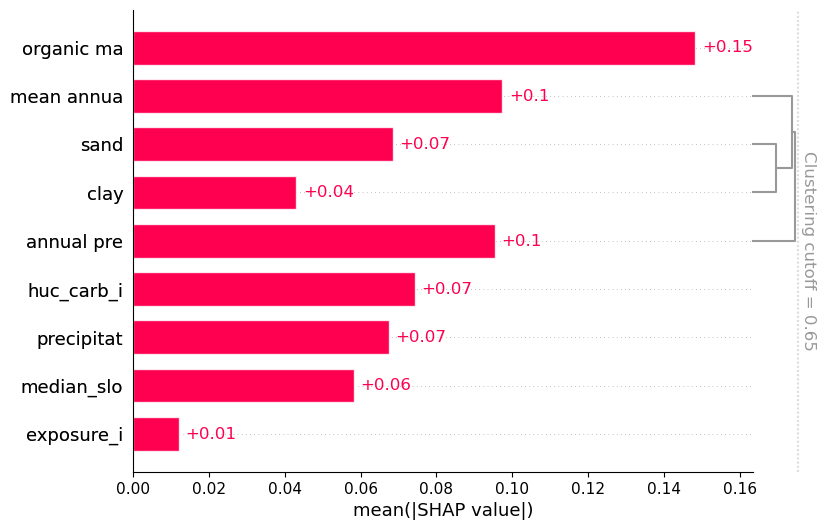

In [50]:
shap.plots.bar(Exp_sel, clustering=clustering, clustering_cutoff=0.65)

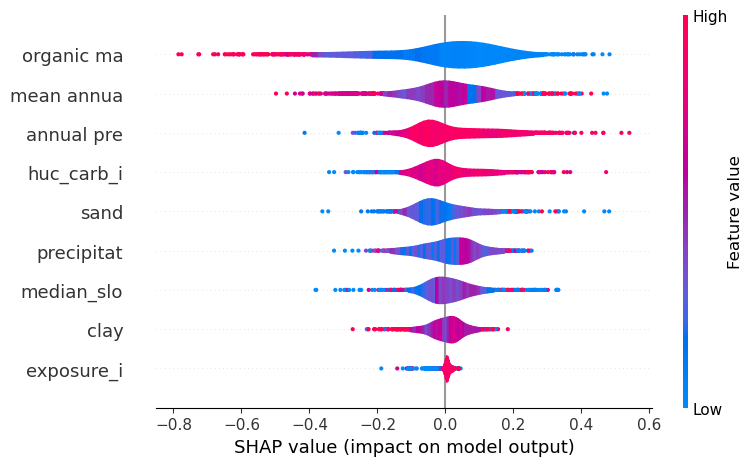

In [55]:
shap.violin_plot(Exp_sel)

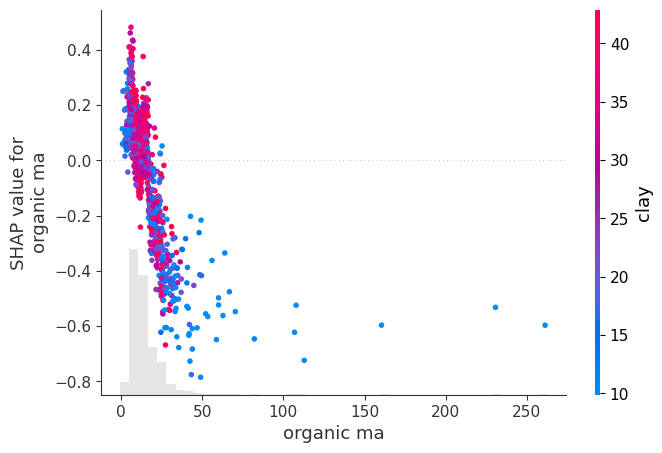

In [44]:
shap.plots.scatter(Exp_sel[:,'organic ma'], color=Exp_sel)

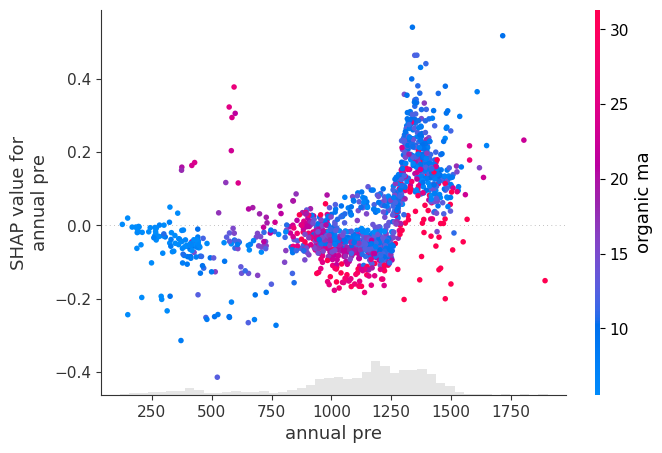

In [45]:
shap.plots.scatter(Exp_sel[:,'annual pre'], color=Exp_sel)

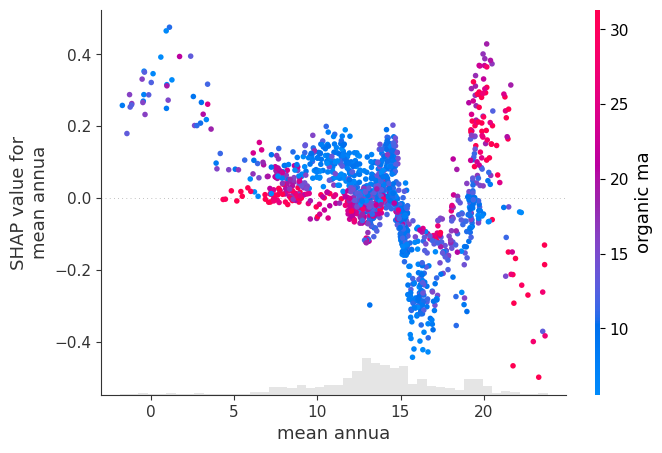

In [46]:
shap.plots.scatter(Exp_sel[:,'mean annua'], color=Exp_sel)

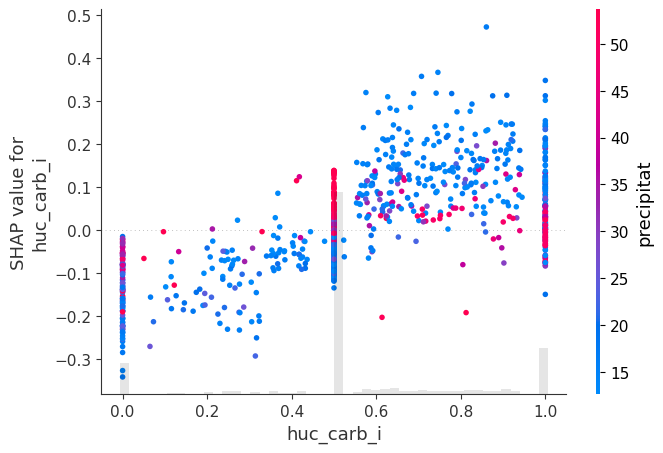

In [51]:
shap.plots.scatter(Exp_sel[:,'huc_carb_i'], color=Exp_sel)

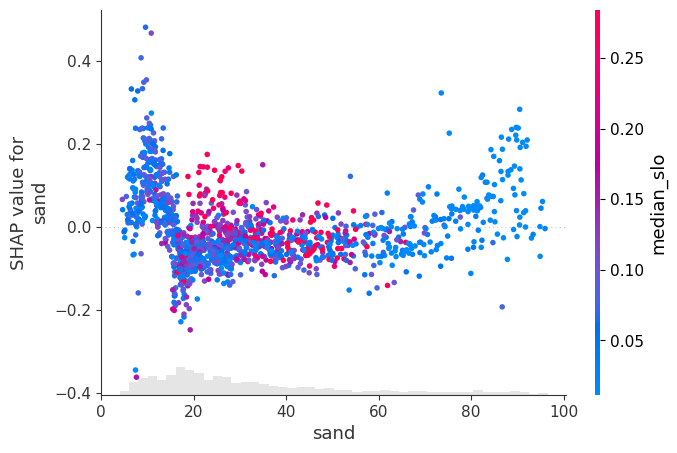

In [52]:
shap.plots.scatter(Exp_sel[:,'sand'], color=Exp_sel)

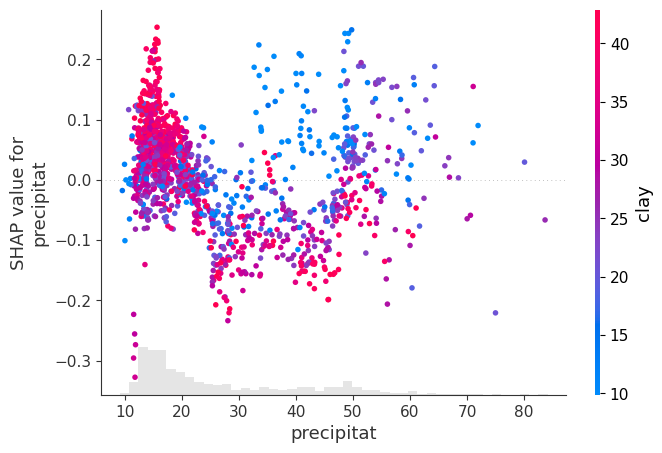

In [53]:
shap.plots.scatter(Exp_sel[:,'precipitat'], color=Exp_sel)

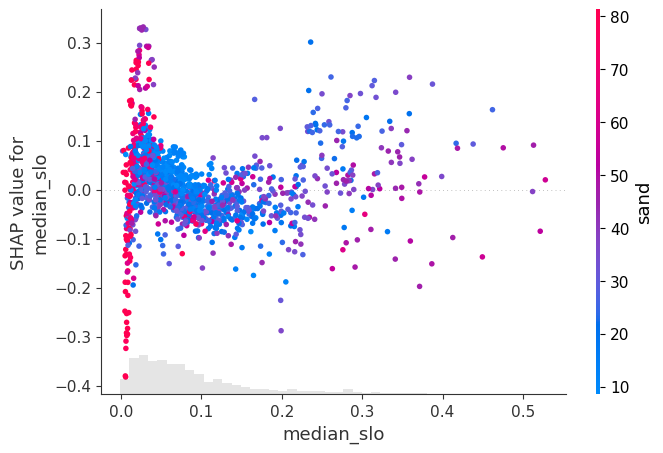

In [54]:
shap.plots.scatter(Exp_sel[:,'median_slo'], color=Exp_sel)

In [57]:
causal_selected_feature_names = selected_features_names[selected_features_names!='organic ma']

In [59]:
X_causal_train = X_train[causal_selected_feature_names]
X_causal_test = X_test[causal_selected_feature_names]


In [60]:
caus_sel = xgboost.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
caus_sel.fit(X_causal_train,y_train, eval_set = [(X_causal_test, y_test)])

[0]	validation_0-rmse:0.80245
[1]	validation_0-rmse:0.77557
[2]	validation_0-rmse:0.75645
[3]	validation_0-rmse:0.74615
[4]	validation_0-rmse:0.73803
[5]	validation_0-rmse:0.73386
[6]	validation_0-rmse:0.72416
[7]	validation_0-rmse:0.72092
[8]	validation_0-rmse:0.72117
[9]	validation_0-rmse:0.71961
[10]	validation_0-rmse:0.71921
[11]	validation_0-rmse:0.71699
[12]	validation_0-rmse:0.71705
[13]	validation_0-rmse:0.71669
[14]	validation_0-rmse:0.71536
[15]	validation_0-rmse:0.71618
[16]	validation_0-rmse:0.71530
[17]	validation_0-rmse:0.71421
[18]	validation_0-rmse:0.71189
[19]	validation_0-rmse:0.71127
[20]	validation_0-rmse:0.70936
[21]	validation_0-rmse:0.71192
[22]	validation_0-rmse:0.71153


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
caus_sel.score(X_causal_test, y_test)

0.3105134336722397

In [63]:

X500_caus = shap.utils.sample(X_causal_train, 500)
explainer_caus = shap.Explainer(caus_sel.predict, X500_caus)
Exp_caus = explainer_caus(X_causal_test)

ExactExplainer explainer: 1379it [00:51, 21.12it/s]                          


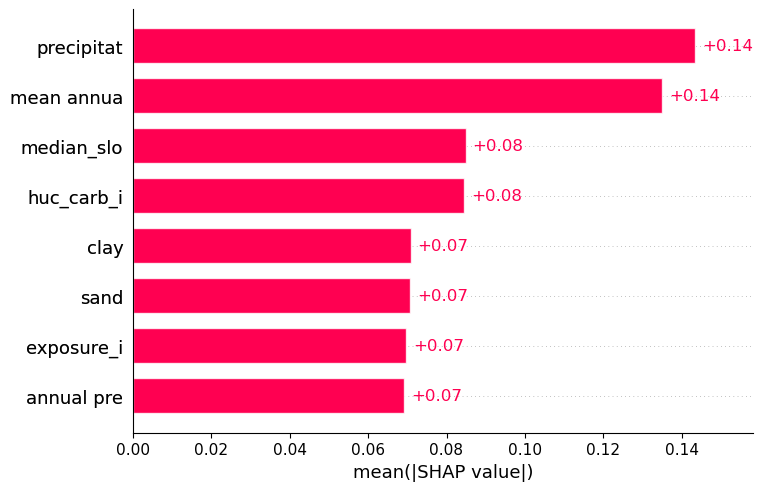

In [64]:
shap.plots.bar(Exp_caus)

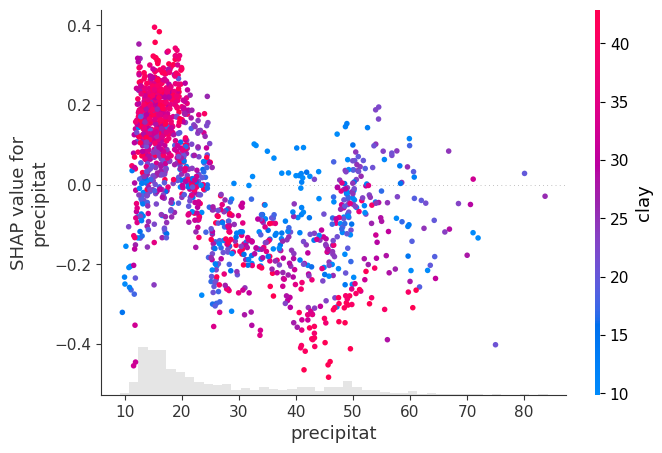

In [65]:
shap.plots.scatter(Exp_caus[:,"precipitat"], color=Exp_caus)

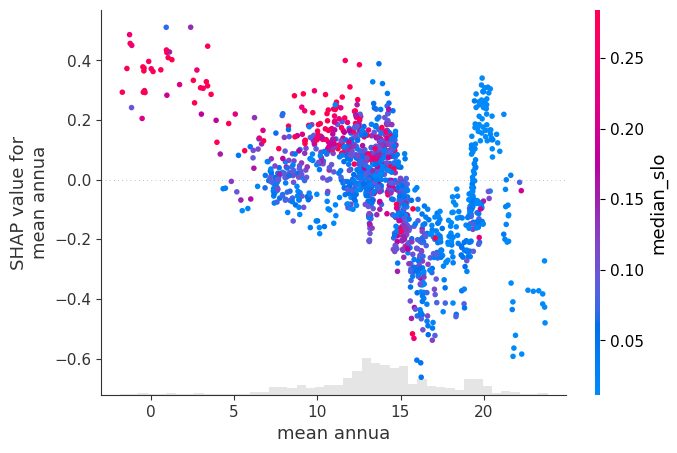

In [66]:
shap.plots.scatter(Exp_caus[:,"mean annua"], color=Exp_caus)

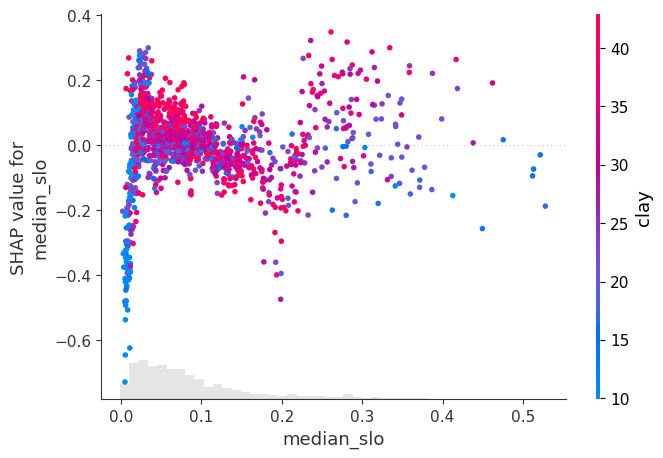

In [67]:
shap.plots.scatter(Exp_caus[:,"median_slo"], color=Exp_caus)

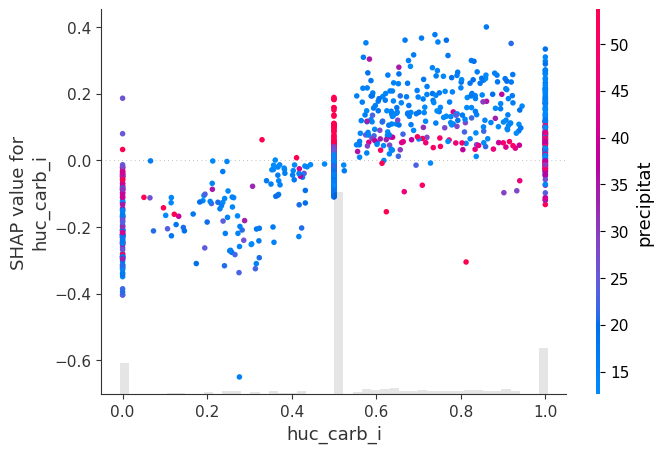

In [68]:
shap.plots.scatter(Exp_caus[:,"huc_carb_i"], color=Exp_caus)